# STATS 503, Group Work Assignment 3

**Instructions:** During lab section, and afterward as necessary, you will collaborate in two-person teams (assigned by the GSI) to complete the problems that are interspersed below. The GSI will help individual teams encountering difficulty, make announcements addressing common issues, and help ensure progress for all teams. **During lab, feel free to flag down your GSI to ask questions at any point!** Upon completion, one member of the team should submit their team's work through Canvas **as html**.

**assignment credits:** Roman Kouznetsov (based on the notes of Gang Qiao)

In this assignment, we first will experiment with logistic regression. The data we will be using is synthetic and manually created by sampling from a multivariate Gaussian distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

np.random.seed(12)
num_observations = 500

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([0, 2], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations,dtype=int),
                              np.ones(num_observations,dtype=int)))

Let us visualize how the generated data looks like:

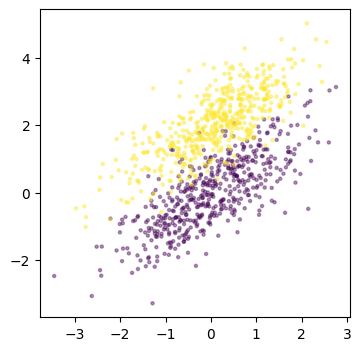

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4,s=5)

We now may need to split the data into training and testing set. We use a 70%/30% split.

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    simulated_separableish_features,simulated_labels,test_size=0.3,random_state=0)

Now import logistic regression model from sklearn and train the model from the training data.

In [ ]:
model_log = sklearn.linear_model.LogisticRegression()
model_log.fit(X_train, y_train)

LogisticRegression()

Logistic Regression has train successfully. We now use our fitted model to predict the probability of the binary outcomes in the test dataset.

In [ ]:
y_prob = model_log.predict_proba(X_test)

# show logistic regression's estimated probability mass function along with the true value of y_i for each test point
viz_table = pd.DataFrame(data = np.c_[y_prob, y_test], columns=['$\hat p(0|x_i)$','$\hat p(1|x_i)$','$y_i$'])
viz_table

,$\hat p(0|x_i)$,$\hat p(1|x_i)$,$y_i$
0,0.014040,0.985960,1.0
1,0.006952,0.993048,1.0
2,0.998837,0.001163,0.0
3,0.001565,0.998435,1.0
4,0.004637,0.995363,1.0
...,...,...,...
295,0.963290,0.036710,0.0
296,0.873139,0.126861,1.0
297,0.097838,0.902162,1.0
298,0.999505,0.000495,0.0


In [ ]:
# compute p(y_i | x_i) for each sample
pygx = y_prob[np.r_[0:len(y_test)], y_test]
viz_table['$\hat p(y_i|x_i)$'] = pygx
viz_table

,$\hat p(0|x_i)$,$\hat p(1|x_i)$,$y_i$,$\hat p(y_i|x_i)$
0,0.014040,0.985960,1.0,0.985960
1,0.006952,0.993048,1.0,0.993048
2,0.998837,0.001163,0.0,0.998837
3,0.001565,0.998435,1.0,0.998435
4,0.004637,0.995363,1.0,0.995363
...,...,...,...,...
295,0.963290,0.036710,0.0,0.963290
296,0.873139,0.126861,1.0,0.126861
297,0.097838,0.902162,1.0,0.902162
298,0.999505,0.000495,0.0,0.999505


In [ ]:
# compute average log likelihood
np.mean(np.log(pygx))

-0.16193651730866185

In [ ]:
# sklearn provides a convenience function for computing the estimated cross-entropy
# i.e., the negative log likelihood (NLL), which is just the negative of what
# we computed above
sklearn.metrics.log_loss(y_test, y_prob)

0.16193651730866185

Now let's make a *hard classifier*, something that makes a single guess about what the response might be, given any input.  This is contrasted with he soft classifier we already have, that estimated the conditional probability of each response given any anput.  

We'll start by making a hard classifier by thresholding our estimate of the conditional pmf.

$$\hat y(x) = \begin{cases} 1 & \mathrm{if}\ \hat p(1|x)>t \\ 0 & \mathrm{otherwise}\end{cases}$$

We'll start with $t=0.6$, which is pretty arbitrary.  You can also play around with different values and see how things change.

In [ ]:
thresh = 0.6
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
pd.DataFrame({'phat(1|x_i)':y_prob[:,1], 'yhat(3|x_i)':y_pred})

,phat(1|x_i),yhat(3|x_i)
0,0.985960,1
1,0.993048,1
2,0.001163,0
3,0.998435,1
4,0.995363,1
...,...,...
295,0.036710,0
296,0.126861,0
297,0.902162,1
298,0.000495,0


In [ ]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[135,   9],
       [ 15, 141]])

In [ ]:
# You can also create a confusion matrix using Pandas
cm_pd = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cm_pd

Predicted,0,1
Actual,,
0,135,9
1,15,141


In [ ]:
# pandas can also create row summaries and column summaries
cm_pd = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
cm_pd

Predicted,0,1,All
Actual,,,
0,135,9,144
1,15,141,156
All,150,150,300


In [ ]:
# look at some metrics that are special for binary classification, where we have
# a "negative" and "positive" class
# here "postitive" is class 1 and "negative" is actually what we are calling class 0

FP = cnf_matrix[0,1] # it is "negative" (class 0) but we predict +1
FN = cnf_matrix[1,0]
TP = cnf_matrix[1,1]
TN = cnf_matrix[0,0]

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


metrics=pd.Series(dict(
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN),
    # Specificity or true negative rate
    TNR = TN/(TN+FP),
    # Precision or positive predictive value
    PPV = TP/(TP+FP),
    # Negative predictive value
    NPV = TN/(TN+FN),
    # Fall out or false positive rate
    FPR = FP/(FP+TN),
    # False negative rate
    FNR = FN/(TP+FN),
    # False discovery rate
    FDR = FP/(TP+FP)
))
metrics

,0
TPR,0.903846
TNR,0.937500
PPV,0.940000
NPV,0.900000
FPR,0.062500
FNR,0.096154
FDR,0.060000


Let's make a curve, evaluating the precision and recall for many different hard classifiers based on many different thresholds.  sklearn makes this easy for you.

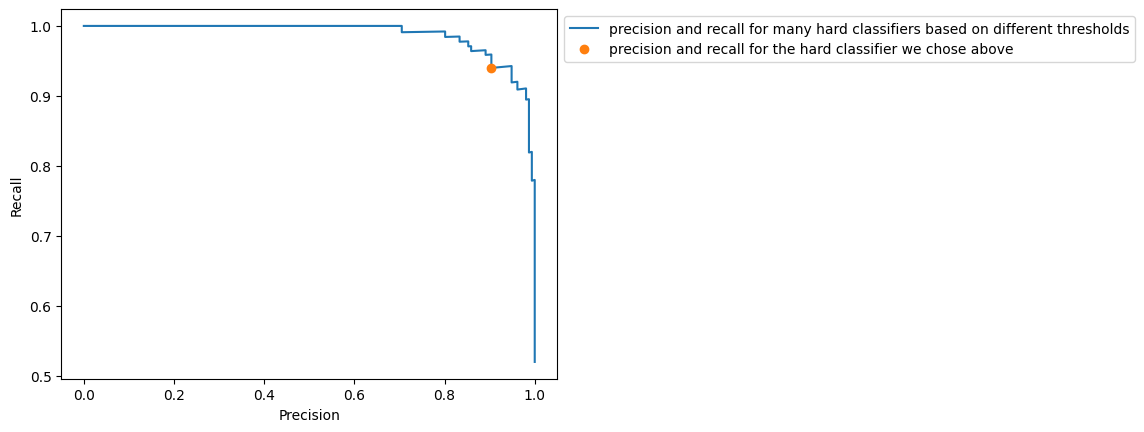

In [ ]:
prec,rec, thresh = sklearn.metrics.precision_recall_curve(y_test,  y_prob[:,1])

plt.plot(rec, prec, label='precision and recall for many hard classifiers based on different thresholds')

plt.plot([metrics.TPR],[metrics.PPV],'o',label='precision and recall for the hard classifier we chose above')


plt.legend(bbox_to_anchor=[1,1])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

# Group Work (30 points)

Now, we demonstrated how to use sklearn's library to plot the precision-recall curve. For group work, we will attempt to use and program the ROC from scratch. The motivation is two-fold:



1.   To better understand how some of the libraries implement the functions you end up using.
2.   To build up the intution for what AUC and ROC actually are instead of just thinking of them as a number.



### Part 1 (1 point)

Just as in last week's lab, load the datasets from NHANES into this notebook.


In [2]:
import pandas as pd

### LOAD YOUR DATASETS HERE.
bmx_df = pd.read_sas('BMX_L.xpt', format = 'xport')
demo_df = pd.read_sas('DEMO_L.xpt', format = 'xport')
hdl_df = pd.read_sas('HDL_L.xpt', format = 'xport')

# Now you can work with the dataframes (bmx_df, demo_df, hdl_df)
# Example: Displaying the first few rows of each dataframe
print("\nFirst few rows of BMX_L.xpt:")
print(bmx_df.head())
print("\nFirst few rows of DEMO_L.xpt:")
print(demo_df.head())
print("\nFirst few rows of HDL_L.xpt:")
print(hdl_df.head())


First few rows of BMX_L.xpt:
       SEQN  BMDSTATS  BMXWT  BMIWT  BMXRECUM  BMIRECUM  BMXHEAD  BMIHEAD  \
0  130378.0       1.0   86.9    NaN       NaN       NaN      NaN      NaN   
1  130379.0       1.0  101.8    NaN       NaN       NaN      NaN      NaN   
2  130380.0       1.0   69.4    NaN       NaN       NaN      NaN      NaN   
3  130381.0       1.0   34.3    NaN       NaN       NaN      NaN      NaN   
4  130382.0       3.0   13.6    NaN       NaN       1.0      NaN      NaN   

   BMXHT  BMIHT  ...  BMXLEG  BMILEG  BMXARML  BMIARML  BMXARMC  BMIARMC  \
0  179.5    NaN  ...    42.8     NaN     42.0      NaN     35.7      NaN   
1  174.2    NaN  ...    38.5     NaN     38.7      NaN     33.7      NaN   
2  152.9    NaN  ...    38.5     NaN     35.5      NaN     36.3      NaN   
3  120.1    NaN  ...     NaN     NaN     25.4      NaN     23.4      NaN   
4    NaN    1.0  ...     NaN     NaN      NaN      1.0      NaN      1.0   

   BMXWAIST  BMIWAIST  BMXHIP  BMIHIP  
0      98.

### Part 2 (2 points)

Just as in last week's lab, let's join these datasets together using their primary key.

In [10]:
# inner join on SEQN
df = bmx_df.merge(hdl_df, on='SEQN', how='inner').merge(demo_df, on='SEQN', how='inner')

### Part 3 (3 points)

Pick out a set of predictors to run a logistic regression with to predict the level of HDL.

1) In the markdown cell, write the column name of the variable along with a short English description of what the variable is.

2) In the coding cell, filter your dataset to only hold the SEQN, your predictors, and your response variables.



In [11]:
### CREATE A FILTERED DATAFRAME CALLED my_df
### RENAME COLUMNS TO BE MORE READABLE
### VIEW THE FIRST FEW ROWS
### CREATE A FILTERED DATAFRAME CALLED my_df
### RENAME COLUMNS TO BE MORE READABLE
### VIEW THE FIRST FEW ROWS
my_df = df[['SEQN', 'LBDHDD', 'BMXBMI', 'RIAGENDR', 'RIDAGEYR', 'INDFMPIR']]

# Rename columns to be more readable
my_df = my_df.rename(columns={
    'LBDHDD': 'HDL_Cholesterol',
    'BMXBMI': 'BMI',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'INDFMPIR': 'Income_Poverty_Ratio'
})

# View the first few rows of the filtered dataframe
print(my_df.head())

       SEQN  HDL_Cholesterol   BMI  Gender   Age  Income_Poverty_Ratio
0  130378.0             45.0  27.0     1.0  43.0                  5.00
1  130379.0             60.0  33.5     1.0  66.0                  5.00
2  130380.0             49.0  29.7     2.0  44.0                  1.41
3  130386.0             46.0  30.2     1.0  34.0                  1.33
4  130387.0             42.0  42.6     2.0  68.0                  1.32


- BMXBMI: Body Mass Index (kg/m²)
- RIAGENDR: Gender
- RIDAGEYR: Age in years
- LBDHDD: Direct HDL-Cholesterol (mg/dL)
- SEQN: Respondent sequence number
- INDFMPIR: Income poverty ratio

### Part 4 (1 point)

Drop all missing values since they do not help us much. If you remove more than 30% of all rows in the dataset, your set of variables is likely removing too much of the data. Try to find a different combination of variables.


In [12]:
### YOUR CODE HERE
my_df = my_df.dropna()

In [13]:
assert my_df.shape[0] / df.shape[0] > 0.7

### Part 5 (1 point)

High-density lipoprotein (HDL) cholesterol is often called the “good” cholesterol because higher levels are generally associated with a lower risk of heart disease.

An HDL of 60 mg/dL or higher is often viewed as protective against heart disease—this is typically the level you’d like to aim for, if possible.

Change your HDL variable to be a binary indicator of being at least 60 mg/dL. Don't forget to rename your variable!

In [14]:
### YOUR CODE HERE
my_df['HDL_ind'] = (my_df['HDL_Cholesterol'] >= 60).astype(int)
my_df.head()

,SEQN,HDL_Cholesterol,BMI,Gender,Age,Income_Poverty_Ratio,HDL_ind
0,130378.0,45.0,27.0,1.0,43.0,5.00,0
1,130379.0,60.0,33.5,1.0,66.0,5.00,1
2,130380.0,49.0,29.7,2.0,44.0,1.41,0
3,130386.0,46.0,30.2,1.0,34.0,1.33,0
4,130387.0,42.0,42.6,2.0,68.0,1.32,0


### Part 6 (2 points)

Separate the data into a training and testing split. Use an 80/20 split. Feel free to leverage code presented earlier in the lab. **Use a random state of 8**.

In [16]:
from sklearn.model_selection import train_test_split

### USE THE TRAIN_TEST_SPLIT APPROPRIATELY HERE
X = my_df[['BMI', 'Gender', 'Age', 'Income_Poverty_Ratio']]
y = my_df['HDL_ind']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

### Part 7 (3 points)

Run your logistic regression. Feel free to leverage code presented earlier in the lab.

In [17]:
from sklearn.linear_model import LogisticRegression

### RUN THE LOGISTIC REGRESSION
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Part 8 (2 points)

Generate both the predicted probabilities and the **default** binary HDL>60 predictions.

In [18]:
### YOUR CODE HERE
# Hint: Use the .predict and .predict_proba methods of your model object.
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

### Part 9 (5 points)

Let's use the ```ROC``` method of the ```LIBRARY``` to evaluate the logistic regression model we developed in lab. This will serve as a sanity check that our own implementation is close to accurate.

We will use the same library to calculate the area under the curve (AUC).

In [19]:
from sklearn.metrics import roc_curve, auc

### USE THE roc_curve METHOD TO GENERATE THE RELEVANT TPR, FPR, & THRESHOLDS.

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

AUC: 0.7382652225235498


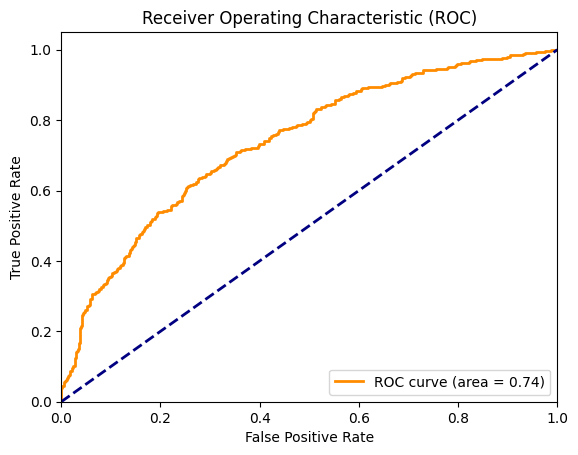

In [20]:
### DO NOT EDIT THIS
print("AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Part 10 (7 points)

Implement your own ROC function and evaluate your logistic regression on it. You may not wrap functions that already do this. Use at least 1000 thresholds.

In [24]:
from sklearn.metrics import confusion_matrix

def roc(y_test, predicted_probs):
  """
    Returns the false positive rate, true positive rate, and thresholds for a given set of predicted probabilities.

    y_test: The true labels of the test set.
    predicted_probs: The predicted probabilities of the positive class for the test set.

    Returns:
    fpr_list: A list of false positive rates for each threshold.
    tpr_list: A list of true positive rates for each threshold.
    thresholds: A list of thresholds used to calculate the rates.
  """
  thresholds = np.linspace(0, 1, 1000)  # 1000 thresholds
  fpr_list = []
  tpr_list = []

  for threshold in thresholds:
      # Convert probabilities to 0/1 predictions at this threshold
      y_pred = (predicted_probs >= threshold).astype(int)

      # confusion_matrix: order = [negative_class(0), positive_class(1)]
      tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

      # Compute TPR and FPR
      # TPR = TP / (TP + FN)
      # FPR = FP / (FP + TN)
      tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
      fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

      tpr_list.append(tpr)
      fpr_list.append(fpr)

  return fpr_list, tpr_list, thresholds


my_fprs, my_tprs, thresholds = roc(y_test, y_pred_prob)

AUC: 0.7382518466996827


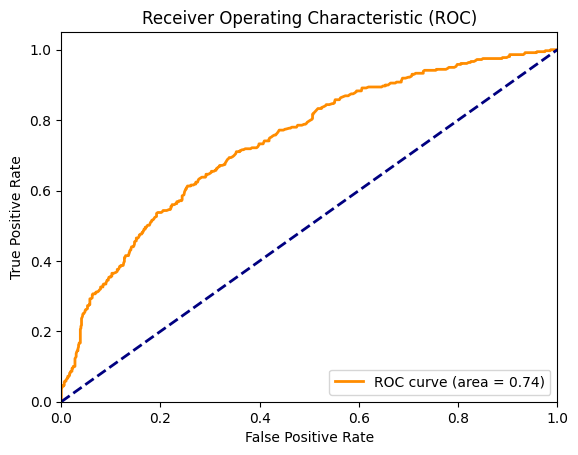

In [25]:
### DO NOT EDIT THIS CELL
roc_auc = auc(my_fprs, my_tprs)
print("AUC:", roc_auc)

plt.figure()
plt.plot(my_fprs, my_tprs, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Part 11 (3 points)

A common final threshold to use, is the one that yields the point on the ROC closest to (0,1). Write some code that recovers this threshold and FPR and TPR at that threshold.

0.2972972972972973
0.35294117647058826
0.7103064066852368


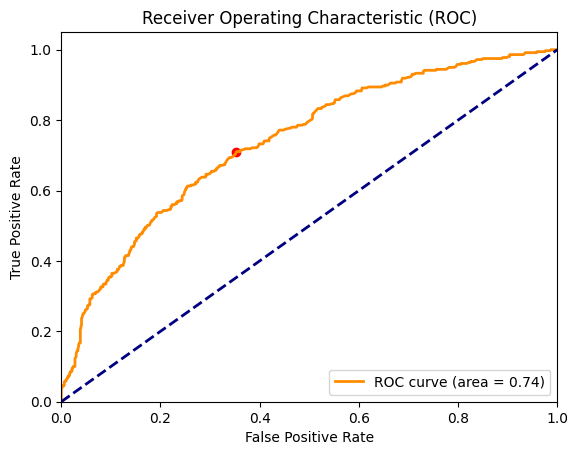

In [26]:
fpr_array = np.array(my_fprs).reshape(-1, 1)
tpr_array = np.array(my_tprs).reshape(-1, 1)

points = np.concatenate((fpr_array, tpr_array), axis=1)
distance = points - np.array([0, 1])
distance = np.linalg.norm(distance, axis=1)
min_index = np.argmin(distance)
print(thresholds[min_index])
print(my_fprs[min_index])
print(my_tprs[min_index])


plt.figure()
plt.plot(my_fprs, my_tprs, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

### Add a point to plot here of your chosen threshold.
### YOUR CODE HERE
plt.scatter(my_fprs[min_index], my_tprs[min_index], color='red', marker='o', label='Chosen Threshold')

plt.show()

The code finds the optimal threshold by calculating the point on the ROC curve closest to (0,1) - the perfect classifier point. This approach balances sensitivity (true positive rate) and specificity (1 - false positive rate).
From the plot, this threshold (≈0.35) yields:

- True Positive Rate ≈ 0.71
- False Positive Rate ≈ 0.35

In [ ]:
!jupyter nbconvert --to html STATS503_GroupWork3.ipynb